In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 1

import cv2
import matplotlib.pyplot as plt
import numpy as np

%aimport lab1
from lab1 import *

np.set_printoptions(precision=6)  # Print less digits

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [843]:
template = load_image('data/hzbook_2.jpg')
original = load_image('data/hzbook_1.jpg')
# homo is the homography matrix that maps points in template to original
homo = np.array([[ 9.01221661e-01, -1.79252179e-01, 1.82000000e+02],
                 [-1.39482959e-01,  5.49034320e-01, 9.40000000e+01],
                 [-1.06281109e-05, -7.07553504e-04, 1.00000000e+00]]).astype(np.float32)

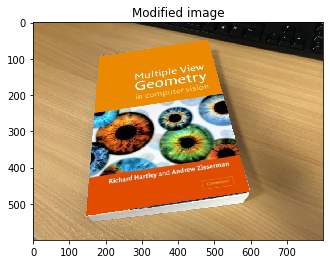

In [992]:
dst = original.copy()
src = template.copy()
h_matrix = homo


dst = dst.copy()  # deep copy to avoid overwriting the original image

""" YOUR CODE STARTS HERE """
#get size
h, w = dst.shape[0:2]

#get points
x,y = np.meshgrid(range(w), range(h))
dst_points = np.array([x.ravel(), y.ravel()]).T
#dst_points = dst_points.astype(np.float32)

#transformation
H_inv = np.linalg.inv(h_matrix)
m_xy = transform_homography(dst_points, H_inv)

#remap
map_x = m_xy[:,0].reshape(h,w).astype(np.float32)
map_y = m_xy[:,1].reshape(h,w).astype(np.float32)

dst_mp = []

dst_mp = cv2.remap(src, map_x, map_y, interpolation = cv2.INTER_LINEAR, borderMode = cv2.BORDER_TRANSPARENT)



plt.figure()
plt.imshow(dst_mp)
plt.title('Modified image');

In [1082]:
src.shape

(475, 332, 3)

[[[ 16 195 116]
  [ 35 196  85]
  [  0   0  72]
  ...
  [ 12  13  15]
  [  8   9  11]
  [ 11  12  14]]

 [[172 130  72]
  [171 129  71]
  [171 129  71]
  ...
  [100 101 103]
  [132 133 135]
  [ 45  46  48]]

 [[170 128  70]
  [171 129  71]
  [171 129  71]
  ...
  [101 102 104]
  [114 115 117]
  [ 25  26  28]]

 ...

 [[141 135 113]
  [126 120  98]
  [111 105  81]
  ...
  [139 107  66]
  [138 106  65]
  [138 106  65]]

 [[138 133 111]
  [121 116  94]
  [113 108  86]
  ...
  [139 107  66]
  [138 106  65]
  [138 106  65]]

 [[131 129 106]
  [128 126 103]
  [130 125 103]
  ...
  [139 107  66]
  [138 106  65]
  [138 106  65]]]


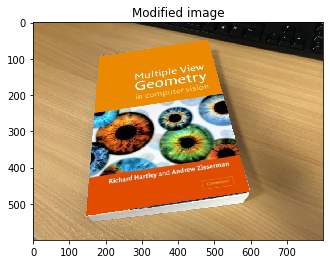

In [1066]:
dst_mp = []

dst_mp = cv2.remap(src, map_x, map_y, interpolation = cv2.INTER_LINEAR, borderMode = cv2.BORDER_TRANSPARENT)
print(dst_mp)


plt.figure()
plt.imshow(dst_mp)
plt.title('Modified image');

In [1028]:
cv2.remap(src, map_x, map_y, interpolation = cv2.INTER_LINEAR, borderMode = cv2.BORDER_TRANSPARENT)

array([[[ 16, 195, 116],
        [ 35, 196,  85],
        [  0,   0,  72],
        ...,
        [ 12,  13,  15],
        [  8,   9,  11],
        [ 11,  12,  14]],

       [[172, 130,  72],
        [171, 129,  71],
        [171, 129,  71],
        ...,
        [100, 101, 103],
        [132, 133, 135],
        [ 45,  46,  48]],

       [[170, 128,  70],
        [171, 129,  71],
        [171, 129,  71],
        ...,
        [101, 102, 104],
        [114, 115, 117],
        [ 25,  26,  28]],

       ...,

       [[141, 135, 113],
        [126, 120,  98],
        [111, 105,  81],
        ...,
        [139, 107,  66],
        [138, 106,  65],
        [138, 106,  65]],

       [[138, 133, 111],
        [121, 116,  94],
        [113, 108,  86],
        ...,
        [139, 107,  66],
        [138, 106,  65],
        [138, 106,  65]],

       [[131, 129, 106],
        [128, 126, 103],
        [130, 125, 103],
        ...,
        [139, 107,  66],
        [138, 106,  65],
        [138, 106,  65]]

In [954]:
dst_points

array([[  0.,   0.],
       [  1.,   0.],
       [  2.,   0.],
       ...,
       [797., 599.],
       [798., 599.],
       [799., 599.]], dtype=float32)

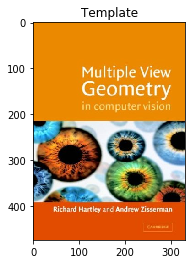

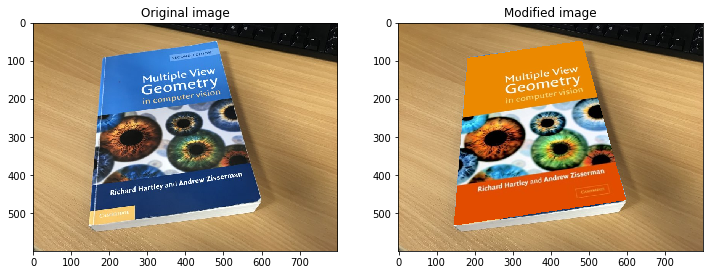

In [816]:
dst = original.copy()
src = template.copy()
h_matrix = homo


dst = dst.copy()  # deep copy to avoid overwriting the original image

""" YOUR CODE STARTS HERE """
#get size
h, w = dst.shape[0:2]

#get points
x,y = np.meshgrid(range(w), range(h))
dst_points = np.array([x.ravel(), y.ravel()]).T


#transformation
H_inv = np.linalg.inv(h_matrix)
m_xy = transform_homography(dst_points, H_inv)

#remap
map_x = m_xy[:,0].reshape(h,w).astype(np.float32)
map_y = m_xy[:,1].reshape(h,w).astype(np.float32)

dst_mp = cv2.remap(src, map_x, map_y, interpolation = cv2.INTER_LINEAR, borderMode = cv2.BORDER_TRANSPARENT)

#merge the two images
result_grey = cv2.cvtColor(dst_mp, cv2.COLOR_BGR2GRAY)
ret, mask = cv2.threshold(result_grey, 10, 255, cv2.THRESH_BINARY)
mask_inv = cv2.bitwise_not(mask)
roi = cv2.bitwise_and(dst_mp, dst_mp, mask=mask)
im2 = cv2.bitwise_and(dst, dst, mask=mask_inv)
dst = cv2.add(im2, roi)

plt.figure()
plt.imshow(template)
plt.title('Template')
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(original)
plt.title('Original image')
plt.subplot(1,2,2)
plt.imshow(dst_mp)
plt.title('Modified image');

In [245]:
dst_points

array([[  0,   0],
       [  1,   0],
       [  2,   0],
       ...,
       [797, 599],
       [798, 599],
       [799, 599]])